In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Inconsolata'

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e14/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e14/test.csv')

# Quick EDA

The following summary method was inspired by the summary function in the notebook https://www.kaggle.com/code/kimtaehun/simple-eda-and-baseline-in-2mintues by DATAMANYO (as well as other parts of the EDA).

In [4]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all')[1:].transpose())
    combined_df = pd.concat([summ, desc], axis=1)
    
    return combined_df

In [5]:
summary(train)

data shape: (15289, 18)


,data type,#missing,%missing,#unique,mean,std,min,25%,50%,75%,max
id,int64,0,0.0,15289,7644.000000,4413.698468,0.000000,3822.000000,7644.000000,11466.000000,15288.000000
clonesize,float64,0,0.0,6,19.704690,6.595211,10.000000,12.500000,25.000000,25.000000,40.000000
honeybee,float64,0,0.0,7,0.389314,0.361643,0.000000,0.250000,0.500000,0.500000,18.430000
bumbles,float64,0,0.0,11,0.286768,0.059917,0.000000,0.250000,0.250000,0.380000,0.585000
andrena,float64,0,0.0,16,0.492675,0.148115,0.000000,0.380000,0.500000,0.630000,0.750000
osmia,float64,0,0.0,14,0.592355,0.139489,0.000000,0.500000,0.630000,0.750000,0.750000
MaxOfUpperTRange,float64,0,0.0,6,82.169887,9.146703,69.700000,77.400000,86.000000,86.000000,94.600000
MinOfUpperTRange,float64,0,0.0,5,49.673281,5.546405,39.000000,46.800000,52.000000,52.000000,57.200000
AverageOfUpperTRange,float64,0,0.0,5,68.656256,7.641807,58.200000,64.700000,71.900000,71.900000,79.000000
MaxOfLowerTRange,float64,0,0.0,6,59.229538,6.610640,50.200000,55.800000,62.000000,62.000000,68.200000


The summary of the training dataset shows that there are no missing values. As expected, the features are on varying scales. It is noteworthy that although all columns except for the ID column are float values, a considerable number of them have only a few unique values.

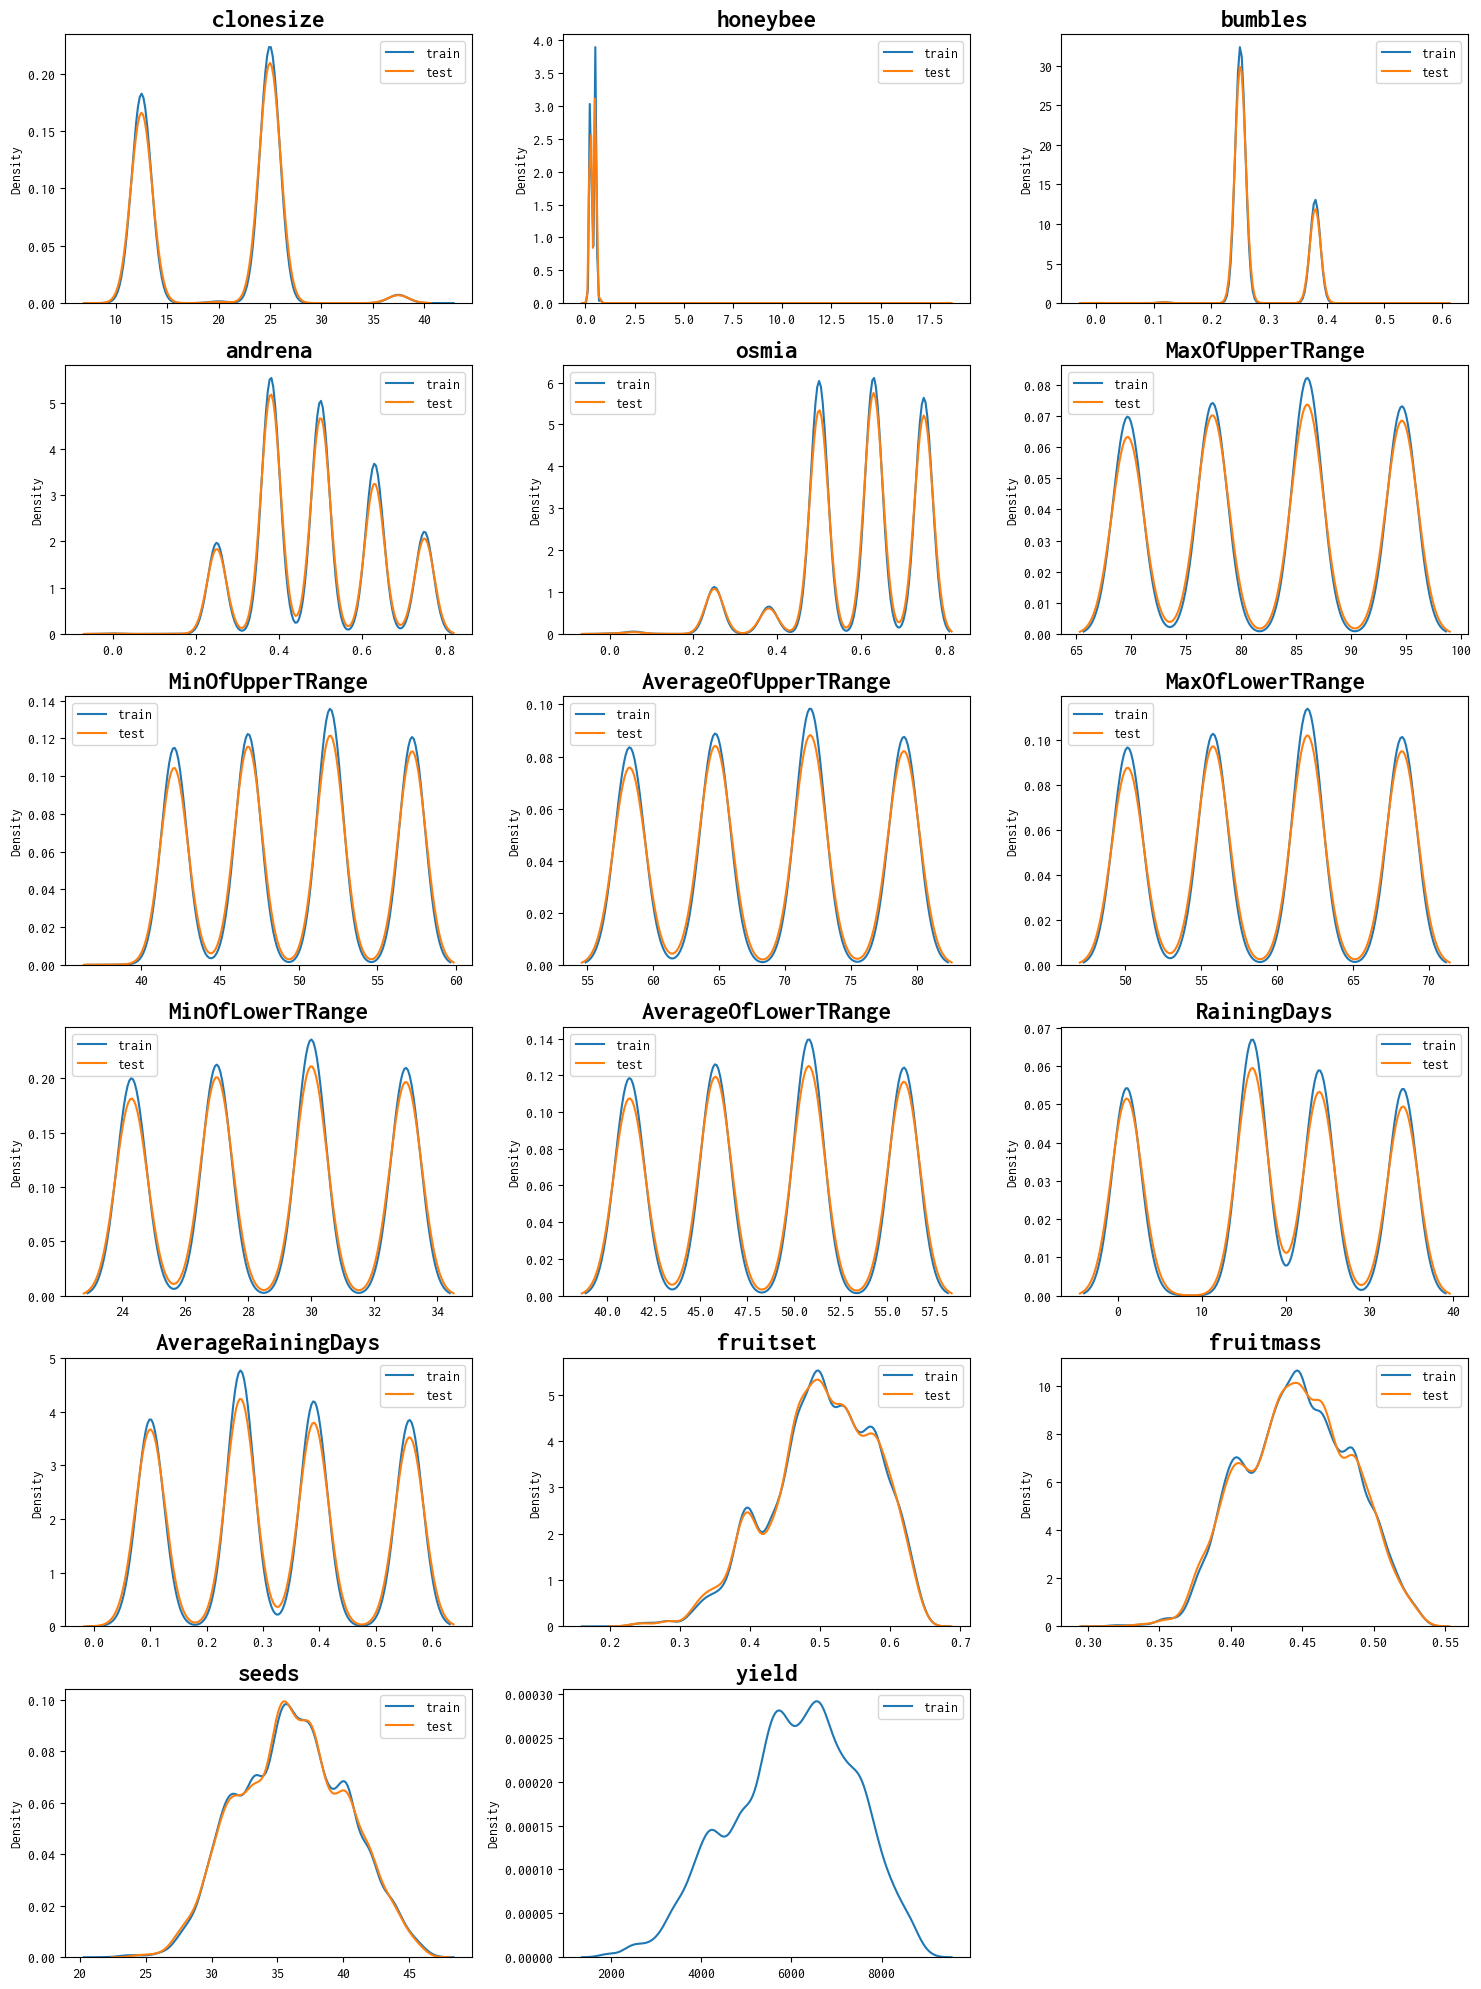

In [6]:
cols = train.drop('id', axis=1).columns
nrows = 6
ncols = 3

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 20))
axs = axs.flatten()

for i, col in enumerate(cols):
    sns.kdeplot(train[col], ax=axs[i], label='train')
    if col != 'yield':
        sns.kdeplot(test[col], ax=axs[i], label='test')
    axs[i].set_xlabel('')
    axs[i].set_title(col,fontweight='bold', fontsize = 18)
    axs[i].legend()

if len(cols) < nrows*ncols:
    for i in range(len(cols), nrows*ncols):
        fig.delaxes(axs[i])
        
plt.tight_layout()

We can observe that both datasets have almost identical distributions. The variables that differ the most between the datasets are fruitset, fruitmass, and seeds, although their distributions are still very similar. We can also observe that the target variable follows a distribution that is similar to a normal distribution.

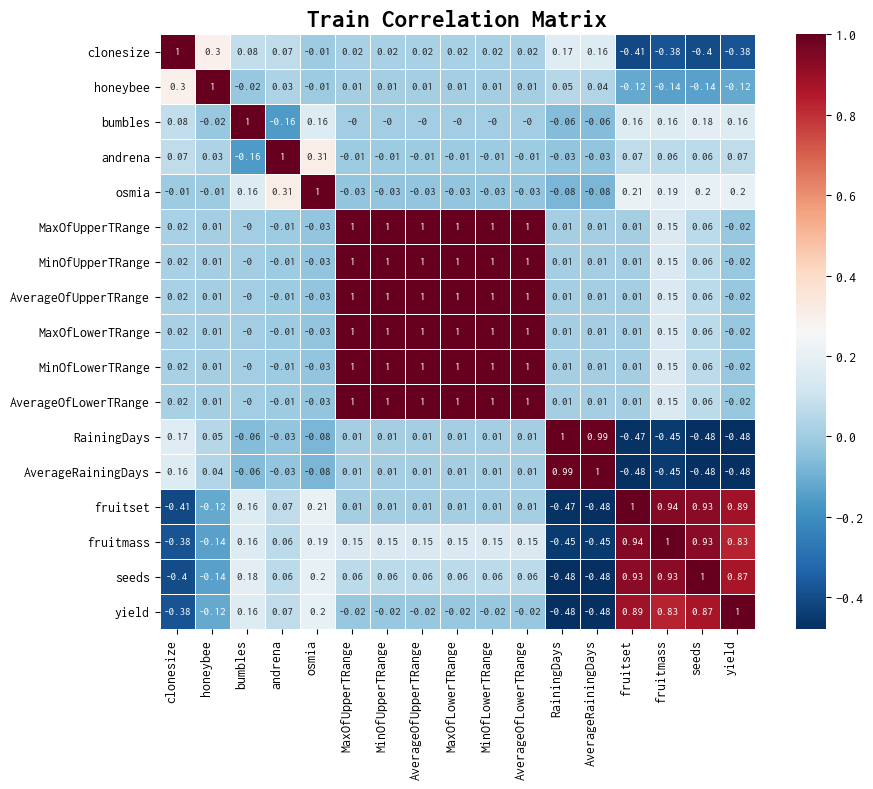

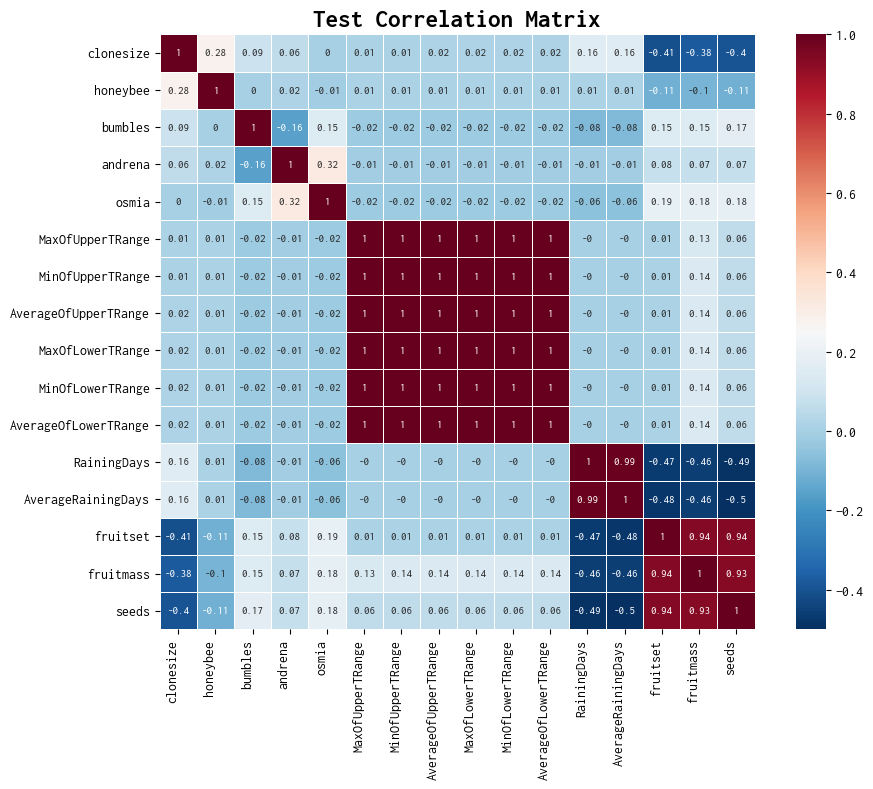

In [7]:
def corr_mat(df, train = True):
    
    # Compute the correlation matrix
    corr_matrix = df.drop('id', axis=1).corr()

    # Set up the figure and plot the matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix.round(2), annot=True, cmap='RdBu_r',
                ax=ax, annot_kws={"size": 8}, square=True, linewidths=0.5)
    
    title = 'Train'
    if not train:
        title = 'Test'
        
    # Customize the plot
    ax.set_title(f'{title} Correlation Matrix', fontweight='bold', fontsize = 18)
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()
    
corr_mat(train)
corr_mat(test, train = False)

The first thing we see is that both sets have a similar correlation matrix. Since the "\_TRange" features are highly correlated with each other and can potentially cause high dimensionality problems for certain models, we will select the feature that has the highest absolute correlation with the target variable and drop the others. Similarly, we will drop the feature that has the least absolute correlation from 'RainingDays' and 'AverageRainingDays'. The reason for doing this is that the correlation between the variables is greater than 0.99, which is like having the same variable more than once. However, we should also consider that having more than 15,000 samples in a dataset with 16 features may be more than enough, so feature selection or dimensionality reduction techniques are not really necessary in this dataset. Therefore, since we will have 10 features after dropping the previous columns, we will not apply any selection or reduction techniques.

In [8]:
corr_matrix = train.corr().abs()

# Drop TRange columns
trange_cols = [col for col in train.columns if col.endswith('TRange')]
max_corr = corr_matrix.loc[trange_cols, 'yield'].max()
best_trange_col = corr_matrix.loc[trange_cols, 'yield'][corr_matrix.loc[trange_cols, 'yield'] == max_corr].index[0]
trange_cols.remove(best_trange_col)
train.drop(trange_cols, axis=1, inplace=True)

#Drop rain column
target_corr = corr_matrix['yield']
if target_corr['RainingDays'] < target_corr['AverageRainingDays']:
    rain_col = 'RainingDays'
else:
    rain_col = 'AverageRainingDays'
train.drop(rain_col, axis=1, inplace=True)

### Outliers

In [9]:
# Calculate z-scores for each column of the dataframe
z_scores = stats.zscore(train.drop(['id'], axis = 1))

# Define a threshold for the z-score
threshold = 4

# Create a boolean array indicating which data points are outliers
outliers = ((z_scores > threshold) | (z_scores < -threshold)).any(axis=1)

# Print the number of outliers and the percentage of the dataset they represent
print(f"Number of outliers: {sum(outliers)}")
print(f"Percentage of dataset: {100 * sum(outliers) / len(train):.2f}%")

cols_3 = z_scores.columns[(z_scores[outliers].max() > threshold) | (z_scores[outliers].min() < -threshold)]
print('Conflict columns:', cols_3)
outliers = z_scores[outliers]
outliers

Number of outliers: 17
Percentage of dataset: 0.11%
Conflict columns: Index(['honeybee', 'bumbles', 'osmia', 'fruitset'], dtype='object')


,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,AverageRainingDays,fruitset,fruitmass,seeds,yield
841,0.802929,0.306073,4.560336,0.927179,-0.662120,0.418756,1.438832,-0.455834,-0.372880,-0.296117,-0.650867
2008,0.044778,-1.076550,-4.786246,-3.326411,-0.052733,0.418756,-1.611819,-2.176700,-1.836810,-2.217334,0.004328
2263,0.044778,49.886963,-4.786246,-3.326411,-4.246749,0.418756,-1.611819,0.205047,-2.209503,-2.247249,-0.759328
4596,0.044778,-1.076550,4.977594,-3.326411,-4.246749,0.418756,-1.611819,-1.576044,-1.518661,-1.638683,-1.516170
4632,0.044778,-1.076550,-4.085252,-2.644487,-4.096194,0.418756,-1.611819,-2.301782,-3.397557,-1.951966,1.825481
5940,0.044778,49.886963,0.104020,-1.746507,-3.830932,-0.521504,1.438832,-1.755104,-2.008249,-1.603255,-1.247743
6035,-1.471523,0.408388,-2.833478,-0.564954,-4.103364,1.359016,-1.611819,-0.384187,-0.314128,-0.313820,-0.207652
6549,0.044778,-1.076550,-4.085252,-2.333907,-4.096194,0.418756,-1.611819,0.079777,-3.635347,-3.494396,0.160312
6818,0.044778,17.284694,1.556078,0.049454,1.130194,-0.521504,-1.367767,0.931688,0.817718,1.086808,0.788957
9553,3.077381,-1.076550,4.977594,-3.326411,-4.246749,1.359016,1.438832,-1.587745,-1.451779,-1.360642,-1.552870


In [10]:
# We count the number of training outliers and testing outliers (using training values)

min_max_thresholds = dict()
for col in cols_3:
    mean = np.mean(train[col])
    std = np.std(train[col])
    val_n = mean + threshold * std
    val_neg_n = mean - threshold * std
    min_max_thresholds[col] = (val_neg_n, val_n)
    train_over = train[train[col] > val_n]
    train_under = train[train[col] < val_neg_n]
    print(f"{col}:\n- {len(train_over)} train samples over {threshold} standard deviations | {len(train_under)} train samples under -{threshold} standard deviations")
    if col != 'yield':    
        test_over = test[test[col] > val_n]
        test_under = test[test[col] < val_neg_n]
        print(f"- {len(test_over)} test samples over {threshold} standard deviations | {len(test_under)} test samples under -{threshold} standard deviations")

honeybee:
- 8 train samples over 4 standard deviations | 0 train samples under -4 standard deviations
- 6 test samples over 4 standard deviations | 0 test samples under -4 standard deviations
bumbles:
- 3 train samples over 4 standard deviations | 8 train samples under -4 standard deviations
- 1 test samples over 4 standard deviations | 9 test samples under -4 standard deviations
osmia:
- 0 train samples over 4 standard deviations | 11 train samples under -4 standard deviations
- 0 test samples over 4 standard deviations | 6 test samples under -4 standard deviations
fruitset:
- 0 train samples over 4 standard deviations | 1 train samples under -4 standard deviations
- 0 test samples over 4 standard deviations | 0 test samples under -4 standard deviations


It seems that the few outliers we have in the training set have their counterparts in the test set, so it would be better not to remove them as it could affect the model's performance on the test set.

# Model

In [11]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train.drop(['id','yield'], axis = 1))
y_train = train['yield']

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}


rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose = 2)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=1, min_s

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50]},
             scoring='neg_mean_absolute_error', verbose=2)

In [12]:
# get the top 10 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
for i,row in results_df.sort_values(by=['rank_test_score']).head(10).iterrows():
    print(row['params'], -row['mean_test_score'],row['std_test_score'])

{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50} 352.54697042104647 3.764404941482482
{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50} 352.54697042104647 3.764404941482482
{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50} 352.54697042104647 3.764404941482482
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50} 353.54845042524505 4.078593644046382
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50} 353.9124439690316 3.9423307854361234
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50} 353.9686495940317 3.794591334665743
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50} 354.0970472023185 3.4489767737495165
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50} 354.6601010573051 3.595173359313381
{'max_depth': 10, 'min_

### Prediction

In [13]:
# Preprocess data
test.drop(trange_cols, axis=1, inplace=True)
test.drop(rain_col, axis=1, inplace=True)

# Scale the data
X_test_scaled = scaler.transform(test.drop(['id'], axis = 1))

# Make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
submission_df = pd.DataFrame({'id': test['id'], 'yield': y_pred})
submission_df.to_csv('submission.csv', index=False)

# Conclusion

A random forest was chosen as a baseline model, but any simple model such as a Linear Regressor could have been used. The next steps would be to conduct a more thorough EDA and feature engineering and explore more advanced models to improve the performance.